# Andrew Bui

In [90]:
import pandas as pd
import datetime
import numpy as np
from matplotlib import pyplot as plt
import plotly.graph_objects as go
from plotly import colors
from tqdm.notebook import tqdm
from typing import Dict, List
from plotly.subplots import make_subplots
from scipy import stats
import plotly.express as px
import functools
import quandl
from patsy import dmatrices
import statsmodels.api as sm

import scipy as sp

import optuna
from optuna.trial import Trial
import optuna.integration.lightgbm as lgb

%matplotlib inline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier
pd.set_option('use_inf_as_na', True)
from collections import Counter
import pickle

import random
from sklearn.preprocessing import MinMaxScaler,StandardScaler

import lightgbm
from lightgbm import LGBMClassifier
from lightgbm import early_stopping
from lightgbm import log_evaluation

import optuna
from optuna.trial import Trial
optuna.logging.set_verbosity(optuna.logging.FATAL)
import warnings

warnings.filterwarnings("ignore")

from functools import partial
import seaborn as sns


In [91]:
# %pip install seaborn


# Load Securities Data

In [2]:
raw_df = pd.read_pickle("/Users/tb/Downloads/dataset.pkl")  
raw_df

actq      apq        atq       ceqq      cheq  \
date       ticker                                                      
2000-02-01 LLB        3.540    0.143      7.668      6.732     2.553   
2000-02-03 MYR      107.661   24.387    220.463    136.555     1.049   
2000-02-08 LZB      447.719   57.893    740.905    460.612    16.531   
           SJM      234.415   33.821    488.136    322.432    26.054   
2000-02-09 CSCO    7722.000  482.000  21391.000  16523.000  3968.000   
...                     ...      ...        ...        ...       ...   
2018-12-31 ELLO      77.786    1.907    255.123     90.949    61.530   
           MFCB      84.040   20.586    252.126    186.153    59.330   
           MFCB      79.628   16.437    242.757    193.929    56.640   
           PETZ      13.670    6.395     18.833      6.459     2.524   
           SGOC      15.429    0.088    156.187     98.344     5.608   

                      cogsq     csh12q    cshfdq     cshiq  cshopq  ...  \
date       ticker                                                   ...   
2000-02-01 LLB        0.458     6.3910     6.391     6.989     0.0  ...   
2000-02-03 MYR       36.883    25.5360    22.082    28.458     0.0  ...   
2000-02-08 LZB      274.525    52.2660    52.274    52.544     0.0  ...   
           SJM       91.172    28.8808    28.603    32.425     0.0  ...   
2000-02-09 CSCO    1422.000  3374.1250  3648.000  3445.000     0.0  ...   
...                     ...        ...       ...       ...     ...  ...   
2018-12-31 ELLO       2.272    10.9220    10.676       NaN     0.0  ...   
           MFCB      76.382    12.5350    12.535    12.600     0.0  ...   
           MFCB       4.650    12.5350    12.535    12.600     0.0  ...   
           PETZ      12.253     9.3245     9.424     9.424     0.0  ...   
           SGOC       0.712    15.6510    18.931    24.844     0.0  ...   

                   sector_code_815.0  sector_code_817.0  sector_code_822.0  \
date       ticker                                                            
2000-02-01 LLB                     0                  0                  0   
2000-02-03 MYR                     0                  0                  0   
2000-02-08 LZB                     0                  0                  0   
           SJM                     0                  0                  0   
2000-02-09 CSCO                    0                  0                  0   
...                              ...                ...                ...   
2018-12-31 ELLO                    0                  0                  0   
           MFCB                    0                  0                  1   
           MFCB                    0                  0                  1   
           PETZ                    0                  0                  0   
           SGOC                    0                  0                  0   

                   sector_code_823.0  sector_code_825.0  sector_code_830.0  \
date       ticker                                                            
2000-02-01 LLB                     0                  0                  0   
2000-02-03 MYR                     0                  0                  0   
2000-02-08 LZB                     0                  0                  0   
           SJM                     0                  0                  0   
2000-02-09 CSCO                    0                  0                  0   
...                              ...                ...                ...   
2018-12-31 ELLO                    0                  0                  0   
           MFCB                    0                  0                  0   
           MFCB                    0                  0                  0   
           PETZ                    0                  0                  0   
           SGOC                    0                  0                  0   

                   sector_code_835.0  sector_code_840.0  sector_code_845.0  \
da

In [3]:
def f(x):
    if x > 0.05:
        return 1
    elif x < -0.1:
        return -1
    else:
        return 0
    
data = raw_df.copy()
data['rel_outpf'] = data['pred_rel_return'].apply(f)
data['rel_outpf']

date        ticker
2000-02-01  LLB      -1
2000-02-03  MYR       1
2000-02-08  LZB       1
            SJM       1
2000-02-09  CSCO      0
                     ..
2018-12-31  ELLO      0
            MFCB      0
            MFCB      0
            PETZ      0
            SGOC      0
Name: rel_outpf, Length: 294412, dtype: int64

In [4]:
data.replace([np.inf,-np.inf],np.nan,inplace=True)
data = data.fillna(method='ffill')
data = data.fillna(0)

In [5]:
start_dates = [pd.to_datetime('2001-01-01') + pd.DateOffset(months = 3*i) for i in range(57)]
end_dates = [d + pd.DateOffset(months = 36) for d in start_dates]

In [6]:
training_frames = [data.loc[d:d+pd.DateOffset(months = 36)] for d in start_dates]
valid_frames = [data.loc[d:d+pd.DateOffset(months = 3)] for d in end_dates]
test_frames = [data.loc[d+pd.DateOffset(months = 6):d+pd.DateOffset(months = 9)] for d in end_dates]

In [7]:
training_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_outpf','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in training_frames]

In [8]:
valid_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_outpf','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in valid_frames]

In [9]:
test_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_outpf','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in test_frames]

In [10]:
training_labels = [d['rel_outpf'].values for d in training_frames]
valid_labels = [d['rel_outpf'].values for d in valid_frames] 

## Load Classifiers and Significant Data 

In [12]:
with open(r'/Users/tb/Desktop/Google/UChicago MSFM/Machine Learning /L8/Gradient Boosting Parameters/classifiers_gb_clf_01.pkl','rb') as f:
    classifiers = pickle.load(f)

In [13]:
with open(r'/Users/tb/Desktop/Google/UChicago MSFM/Machine Learning /L8/Gradient Boosting Parameters/significant_features_gb_clf_01.pkl','rb') as f:
    significant_features = pickle.load(f)

In [14]:
new_training_data = []
new_valid_data = []
new_test_data = []

In [15]:
for i in range(len(start_dates)-1): 
    new_training_data.append(training_data[i][significant_features[i]['cols']])
    new_valid_data.append(valid_data[i][significant_features[i]['cols']])
    new_test_data.append(test_data[i][significant_features[i]['cols']])

In [16]:
for i in range(len(start_dates)-1):
    float_vars = [x for x in new_training_data[i].columns if data[x].dtype == 'float64']

    scaler = StandardScaler()
    new_training_data[i] = new_training_data[i].copy()
    new_valid_data[i] = new_valid_data[i].copy()
    new_test_data[i] = new_test_data[i].copy()
    new_training_data[i][float_vars] = scaler.fit_transform(new_training_data[i][float_vars])
    new_valid_data[i][float_vars] = scaler.transform(new_valid_data[i][float_vars])
    new_test_data[i][float_vars] = scaler.transform(new_test_data[i][float_vars])

In [17]:
for i in range(len(start_dates)-1): 
    classifiers[i].fit(new_training_data[i],training_labels[i])

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


## Load Shap Features Data

In [18]:
with open(r'/Users/tb/Desktop/Google/UChicago MSFM/Machine Learning /L8/Gradient Boosting Parameters/shap_features_gb_clf_01.pkl','rb') as f:
    gb_shap_features = pickle.load(f)

In [19]:
gb_shap_features

[Index(['prccq', 'evmq', 'market_cap', 'efftaxq', 'int_debtq', 'rect_turnq',
        'oancfy_q', 'capeiq', 'chechy', 'cash_conversionq',
        ...
        'spcsrc_B-', 'miiy', 'teqq', 'spcsrc_B', 'pe_op_basicq', 'atq',
        'capital_ratioq', 'pstkq', 'pe_incq', 'sic_6798'],
       dtype='object', length=179),
 Index(['prccq', 'capeiq', 'oancfy_q', 'chechy', 'evmq', 'efftaxq',
        'market_cap', 'pay_turnq', 'cf_yield', 'oepsxy',
        ...
        'spcsrc_B', 'at4', 'cshprq', 'saleq', 'spcsrc_B+', 'pstkq', 'piq',
        'ceqq', 'teqq', 'ibcomq'],
       dtype='object', length=175),
 Index(['rd_saleq', 'fcf_yield', 'oancfy_q', 'fqtr_2', 'dvpspq', 'capeiq',
        'cf_yield', 'curr_ratioq', 'invtq', 'epsfiq'],
       dtype='object'),
 Index(['oancfy_q', 'fcf_yield', 'capeiq', 'rd_saleq', 'debt_assetsq',
        'cf_yield', 'market_cap', 'epsfiq', 'pretret_noaq', 'dvpspq'],
       dtype='object'),
 Index(['oancfy_q', 'evmq', 'lt_ppentq', 'oepsxy', 'cfmq', 'prccq', 'cf_yield',
 

### Pick the 10 most common features

In [20]:
df_gb = pd.DataFrame(data = None)

for i in range(len(gb_shap_features)):

        df_gb[i] = gb_shap_features[i].to_frame()


df_gb.fillna(pd.NA, inplace= True)
df_gb['count'] = df_gb.count(axis= 1)
df_gb.sort_values(by = ['count'], ascending= False, inplace= True)
df_gb_use =  df_gb[:10].index

In [21]:
df_gb_use 

Index(['cf_yield', 'fcf_yield', 'evmq', 'dvpspq', 'rect_turnq', 'lt_ppentq',
       'debt_assetsq', 'fcf_ocfq', 'oepsxy', 'dprq'],
      dtype='object')

In [25]:
start_dates = [pd.to_datetime('2001-01-01') + pd.DateOffset(months = 3*i) for i in range(57)]
end_dates = [d + pd.DateOffset(months = 39) for d in start_dates]

In [26]:
training_frames = [data.loc[d:d+pd.DateOffset(months = 39)] for d in start_dates]
test_frames = [data.loc[d+pd.DateOffset(months = 3):d+pd.DateOffset(months = 6)] for d in end_dates]

In [27]:
scalers = [StandardScaler() for i in range(len(start_dates)-1)]
           
opt_training_data = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][df_gb_use].values),columns=df_gb_use ) for i in range(len(start_dates)-1)]
opt_test_data = [pd.DataFrame(scalers[i].transform(test_frames[i][df_gb_use].values),columns=df_gb_use) for i in range(len(start_dates)-1)]

In [28]:
training_labels = [d['rel_outpf'].values for d in training_frames]

In [29]:
x = [1]
ret = []

for i in range(len(start_dates)-1):
        
        classifiers[i].fit(opt_training_data[i],training_labels[i])

        preds = classifiers[i].predict(opt_test_data[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret.append(profit_i)
        num_names = len(opt_test_data[i])
        x.append(x[i] + (x[i]/num_names)*profit_i)

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1

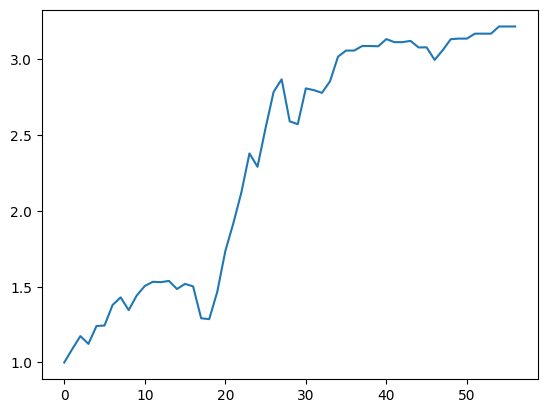

In [30]:
plt.plot(x);

In [31]:
SPY = pd.read_pickle(r'/Users/tb/Downloads/SPY_cum_ret.pkl')
SPY = SPY.loc['2004-09-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy_gb'] = x

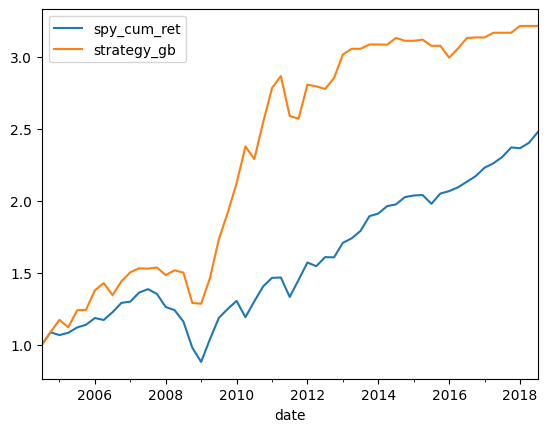

In [32]:
SPY.plot();

In [66]:
strategy_mean_ret = (SPY['strategy_gb'] - 1).diff().mean()
strategy_std = (SPY['strategy_gb'] - 1).diff().std()
gb_strategy_sr = strategy_mean_ret/strategy_std
print('Gradient Boosting Strategy Sharpe Ratio: ',gb_strategy_sr)

Gradient Boosting Strategy Sharpe Ratio:  0.37597506118755464


# Random Forest

In [39]:
start_dates = [pd.to_datetime('2001-01-01') + pd.DateOffset(months = 3*i) for i in range(57)]
end_dates = [d + pd.DateOffset(months = 36) for d in start_dates]

In [41]:
training_frames = [data.loc[d:d+pd.DateOffset(months = 36)] for d in start_dates]
valid_frames = [data.loc[d:d+pd.DateOffset(months = 3)] for d in end_dates]
test_frames = [data.loc[d+pd.DateOffset(months = 6):d+pd.DateOffset(months = 9)] for d in end_dates]

In [43]:
training_labels = [d['rel_outpf'].values for d in training_frames]
valid_labels = [d['rel_outpf'].values for d in valid_frames] 

## Load Optimal Hyperparameters Data

In [35]:
with open(r'/Users/tb/Desktop/Google/UChicago MSFM/Machine Learning /L8/Random Forest Parameters/optimal_hyperparameters.pkl','rb') as f:
     optimal_hyperparameters = pickle.load(f)

In [36]:
classifiers = []

In [37]:
for hyp_par in optimal_hyperparameters:
    rf_clf = RandomForestClassifier(**hyp_par)
    classifiers.append(rf_clf)

In [44]:
for i in range(len(start_dates)-1): 
    classifiers[i].fit(training_data[i],training_labels[i])

In [45]:
def randomforest_feat_importances(m, df):
        
    return pd.DataFrame({'cols':df.columns, 'feat_imp': m.feature_importances_}
                       ).sort_values('feat_imp', ascending=False)

def plot_fi(fi): return fi.plot('cols', 'feat_imp', 'barh', figsize=(12,7), legend=False)

In [46]:
significant_features = []

In [47]:
for i in range(len(start_dates)-1): 
    fi = randomforest_feat_importances(classifiers[i],training_data[i])
    features = fi[(fi['feat_imp'] > 0.00)]['cols'].values
    significant_features.append(features)

In [48]:
significant_features

[array(['prccq', 'epsfi12', 'epspiq', 'ibcomy', 'dvpspq', 'cfmq', 'oepsxq',
        'oepsxy', 'oeps12', 'cf_yield', 'book_value_per_share', 'ibadjq',
        'pe_op_dilq', 'pe_exiq', 'aftret_eqq', 'dprq', 'aftret_equityq',
        'fcf_csfhdq', 'market_cap', 'lagppent_alt4', 'ibcq', 'ibcy',
        'ibcomq', 'epspxq', 'roeq', 'seqq', 'rectq', 'lagseq4', 'ptpmq',
        'dlttq', 'pe_incq', 'txtq', 'dvq', 'debt_ebitdaq', 'lctq4',
        'rd_saleq', 'pe_op_basicq', 'niq', 'oiadpq', 'pretret_noaq',
        'lagicapt4', 'oepf12', 'at_turnq', 'oancfy_q', 'sale_equityq',
        'sale_invcapq', 'ibadj12', 'oancfy', 'oibdpq', 'apq', 'opmadq',
        'rect_turnq', 'epsfxq', 'cshfdq', 'capital_ratioq', 'opepsq',
        'at4', 'pretret_earnatq', 'dvy', 'xinty', 'saleq', 'csh12q',
        'dpcq', 'roaq', 'gprofq', 'actq', 'npmq', 'opcfq', 'int_debtq',
        'lagppent4', 'yearly_sales', 'debt_capitalq', 'epsfiq',
        'book_value_yield', 'oibdpy', 'sale_nwcq', 'dlcchy', 'cshprq',
        '

In [49]:
new_training_data = []
new_valid_data = []
new_test_data = []

In [50]:
for i in range(len(start_dates)-1): 
    new_training_data.append(training_data[i][significant_features[i]])
    new_valid_data.append(valid_data[i][significant_features[i]])
    new_test_data.append(test_data[i][significant_features[i]])

In [51]:
new_valid_data[1].columns

Index(['epsfiq', 'epspi12', 'oepsxy', 'market_cap', 'ibcomq', 'prccq', 'dvy',
       'epspxq', 'oepsxq', 'epsx12',
       ...
       'dlcchy', 'curr_ratioq', 'inv_turnq', 'roceq', 'pe_incq', 'xsgay',
       'dlttq', 'dlcq', 'spcsrc_C', 'xoprq'],
      dtype='object', length=157)

In [52]:
for i in range(len(start_dates)-1):
    float_vars = [x for x in new_training_data[i].columns if data[x].dtype == 'float64']

    scaler = StandardScaler()
    new_training_data[i] = new_training_data[i].copy()
    new_valid_data[i] = new_valid_data[i].copy()
    new_test_data[i] = new_test_data[i].copy()
    new_training_data[i][float_vars] = scaler.fit_transform(new_training_data[i][float_vars])
    new_valid_data[i][float_vars] = scaler.transform(new_valid_data[i][float_vars])
    new_test_data[i][float_vars] = scaler.transform(new_test_data[i][float_vars])

In [53]:
for i in range(len(start_dates)-1): 
    classifiers[i].fit(new_training_data[i],training_labels[i])

In [54]:
start_dates = [pd.to_datetime('2001-01-01') + pd.DateOffset(months = 3*i) for i in range(57)]
end_dates = [d + pd.DateOffset(months = 39) for d in start_dates]

In [55]:
training_frames = [data.loc[d:d+pd.DateOffset(months = 39)] for d in start_dates]
test_frames = [data.loc[d+pd.DateOffset(months = 3):d+pd.DateOffset(months = 6)] for d in end_dates]

In [56]:
training_labels = [d['rel_outpf'].values for d in training_frames]

## Load the shap features data

In [57]:
with open(r'/Users/tb/Desktop/Google/UChicago MSFM/Machine Learning /L8/Random Forest Parameters/shap_features.pkl','rb') as f:
    rf_shap_features = pickle.load(f)

In [58]:
rf_shap_features

[Index(['apq', 'cash_ratioq', 'cf_yield', 'oepsxy', 'rect_actq', 'prccq',
        'cheq', 'roeq', 'book_value_yield', 'niq', 'lagseq4', 'dlttq', 'cfmq',
        'txditcq', 'ibcomy'],
       dtype='object'),
 Index(['cfmq', 'epspi12', 'oeps12', 'saleq', 'epsfi12', 'curr_ratioq',
        'csh12q', 'market_cap', 'dvpspq', 'cfo-per-share', 'capeiq',
        'fcf_yield', 'pe_incq', 'fcf_csfhdq', 'yearly_sales', 'oancfy',
        'pay_turnq', 'lagicapt4', 'oancfy_q', 'prccq', 'lagppent_alt4',
        'rd_saleq', 'cshfdq', 'beq', 'apq', 'cshprq', 'at_turnq', 'cf_yield',
        'quick_ratioq', 'pe_exiq', 'dpcq', 'epsx12', 'actq', 'cash_debtq',
        'cash_ltq', 'seq4', 'epspxq', 'oibdpy', 'ibadj12', 'pcfq', 'dltry',
        'accrualq', 'ibq', 'at5', 'cshiq'],
       dtype='object'),
 Index(['oepsxq', 'oeps12', 'yearly_sales', 'ibadj12', 'oiadpq',
        'aftret_equityq', 'fqtr_4', 'atq', 'roeq', 'oancfy_q', 'cogsq', 'evmq',
        'opepsq', 'ceqq', 'lagseq4', 'pe_op_basicq', 'lagppent4', 

### Pick the 10 most common features

In [59]:
df_rf = pd.DataFrame(data = None)

for i in range(len(rf_shap_features)):

        df_rf[i] = rf_shap_features[i].to_frame()


df_rf.fillna(pd.NA, inplace= True)
df_rf['count'] = df_gb.count(axis= 1)
df_rf.sort_values(by = ['count'], ascending= False, inplace= True)
df_rf_use =  df_rf[:10].index
df_rf_use

Index(['cf_yield', 'oepsxy', 'rect_actq', 'prccq', 'apq', 'ibcomy', 'cheq',
       'dlttq', 'cfmq', 'cash_ratioq'],
      dtype='object')

In [60]:
scalers = [StandardScaler() for i in range(len(start_dates)-1)]
           
opt_training_data = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][df_rf_use].values),columns=df_rf_use) for i in range(len(start_dates)-1)]
opt_test_data = [pd.DataFrame(scalers[i].transform(test_frames[i][df_rf_use].values),columns=df_rf_use) for i in range(len(start_dates)-1)]

In [61]:
x2 = [1]
ret2 = []

for i in range(len(start_dates)-1):
        
        classifiers[i].fit(opt_training_data[i],training_labels[i])

        preds = classifiers[i].predict(opt_test_data[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret2.append(profit_i)
        num_names = len(opt_test_data[i])
        x2.append(x[i] + (x[i]/num_names)*profit_i)

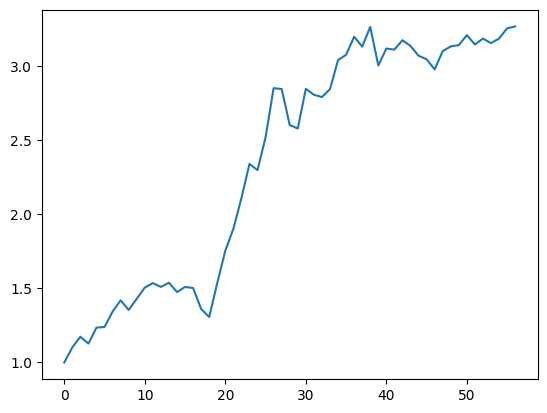

In [62]:
plt.plot(x2);

In [63]:
SPY['strategy_rf'] = x2

<Axes: xlabel='date'>

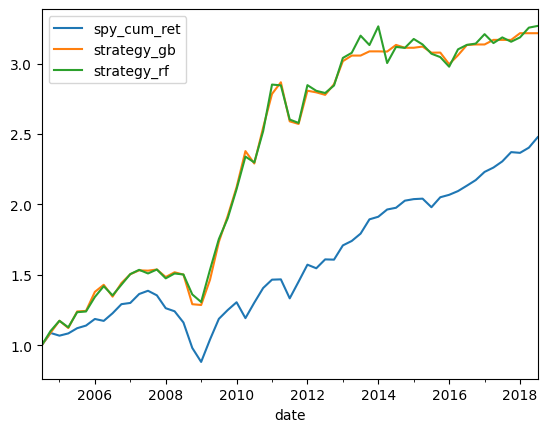

In [64]:
SPY.plot()

In [149]:
strategy_mean_ret = (SPY['strategy_rf'] - 1).diff().mean()
strategy_std = (SPY['strategy_rf'] - 1).diff().std()
rf_strategy_sr = strategy_mean_ret/strategy_std

spy_mean_ret = (SPY['spy_cum_ret'] - 1).diff().mean()
spy_std = (SPY['spy_cum_ret'] - 1).diff().std()
spy_sr = spy_mean_ret/spy_std

print('SPY Sharpe Ratio: ', spy_sr * 2)
print('Random Forest Strategy Sharpe Ratio: ',rf_strategy_sr * 2)
print('Gradient Boosting Strategy Sharpe Ratio: ',gb_strategy_sr *2)

SPY Sharpe Ratio:  0.7849661984123599
Random Forest Strategy Sharpe Ratio:  0.7074632085342779
Gradient Boosting Strategy Sharpe Ratio:  0.7519501223751093


Although the SPY has the highest Sharpe Ratio out of the 3 strategies, the random forest strategy and gradient boosting strategy limit the drawdown and produce much higher cummulative
return (3.22x for gradient boosting strategy and 3.27x for random forest strategy). Both gradient boosting strategy and random forest strategy produce very similar results.

The 2 strategies using the 10 most common features do not produce better performnace than the 2 strategies using the full shap_features sets (4.2x for gradient boosting strategy and 4.5x for random forest strategy). 

# Optimize Portfolio

In [128]:
total_return = (SPY - 1).diff() 
total_return

,spy_cum_ret,strategy_gb,strategy_rf
date,,,
2004-09-30,NaN,NaN,NaN
2004-12-31,0.087381,0.089003,0.101431
2005-03-31,-0.019149,0.084994,0.072503
2005-06-30,0.015900,-0.051407,-0.046658
2005-09-30,0.037100,0.117682,0.107734
2005-12-31,0.018600,0.003655,0.004950
2006-03-31,0.046941,0.135325,0.103124
2006-06-30,-0.013667,0.050303,0.076411
2006-09-30,0.054178,-0.084124,-0.065115


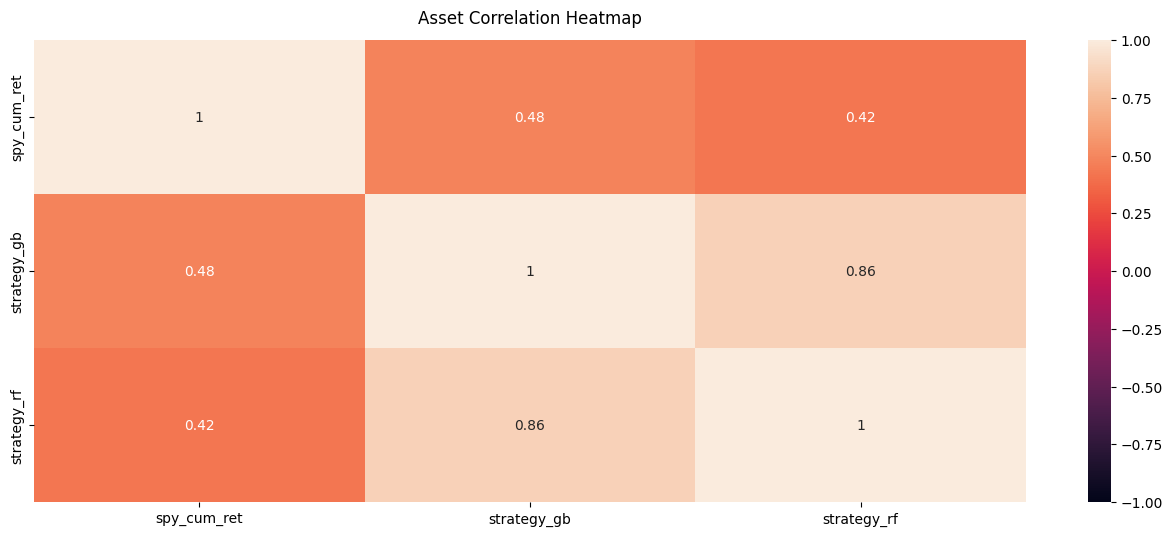

In [129]:
asset_corr = total_return.corr()
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(asset_corr, vmin=-1, vmax=1, annot=True)
heatmap.set_title('Asset Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [130]:
def tangency_portfolio_rfr(asset_return,cov_matrix, cov_diagnolize = False):
    """ 
        Returns the tangency portfolio weights in a (1 x n) vector
        Inputs: 
            asset_return - return for each asset (n x 1) Vector
            cov_matrix = nxn covariance matrix for the assets
    """
    if cov_diagnolize:
        asset_cov = np.diag(np.diag(cov_matrix))
    else:
        asset_cov = np.array(cov_matrix)
    inverted_cov= np.linalg.inv(asset_cov)
    one_vector = np.ones(len(cov_matrix.index))
    
    den = (one_vector @ inverted_cov) @ (asset_return)
    num =  inverted_cov @ asset_return
    return (1/den) * num

In [131]:
tangency_portfolio_rfr(total_return.mean(),total_return.cov(), cov_diagnolize = False)

array([0.63136741, 0.22410972, 0.14452287])

In [147]:
total_return['tangency_return'] = 0.63136741 * total_return['spy_cum_ret'] + 0.22410972 * total_return['strategy_gb'] + 0.14452287 * total_return['strategy_rf']
total_return.mean()/total_return.std()


spy_cum_ret              0.392483
strategy_gb              0.375975
strategy_rf              0.353732
tangency_return          0.449992
tangency2_return         0.380678
tangency_return_short    0.380081
dtype: float64

In [133]:
tangency_portfolio_rfr(total_return[['strategy_gb','strategy_rf']].mean(),total_return[['strategy_gb','strategy_rf']].cov(), cov_diagnolize = False)

array([0.71949934, 0.28050066])

In [136]:
total_return['tangency2_return'] =  0.71949934 * total_return['strategy_gb'] + 0.28050066 * total_return['strategy_rf']

In [144]:
total_return['tangency_return_short'] =  -0.3 * total_return['strategy_gb'] + 0.91949934 * total_return['strategy_gb'] + 0.38050066 * total_return['strategy_rf']

In [148]:
(total_return.mean()*4)/(total_return.std()*2)

spy_cum_ret              0.784966
strategy_gb              0.751950
strategy_rf              0.707463
tangency_return          0.899985
tangency2_return         0.761356
tangency_return_short    0.760162
dtype: float64

The mean-variance optimal portfolio for SPY, gradient boosting strategy and random forest strategy produces sharpe ratio of 0.9 per annum. 

The negative weight on SPY does not produced a better sharp ratio than the mean variance optimal portfolio weight because the positive correlation of the 3 strategies so the negative weight on SPY reduced the return on the portfolio. 